In [1]:
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format ='retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import glob
from chainconsumer import ChainConsumer
import pickle

import la_forge.core as co
import la_forge.diagnostics as dg
from ceffyl import Ceffyl, models, densities, metrics, Sampler

from enterprise.signals import parameter, gp_priors as gpp
from enterprise_extensions.model_utils import get_tspan

from scipy.stats import ks_2samp
from acor import acor
from emcee.autocorr import integrated_time

from ceffyl.bw import bandwidths as bw
from KDEpy import FFTKDE
from scipy.stats import norm

Analytic Gaussian vs numerical Gaussian

$$H^2(g(x)) = 1 - \Sigma\left(\frac{1}{\sqrt{2\pi}}g(x)\exp(-x^2/2)\right)^{1/2}\mathrm{d}x$$

In [3]:
def hellinger(gx, xgrid=None):
    """
    Function to compare KDE pdfs of randoms draws from zero-mean,
    univariate normal to analytical normal
    """
    dx = xgrid[1]-xgrid[0]
    H2 = 1 - np.sum(np.sqrt(gx * np.exp(-xgrid**2/2)/np.sqrt(2*np.pi)))*dx
    
    return np.sqrt(H2)

In [54]:
def general_hellinger(fx, gx, xgrid=None):
    """
    Compare pdfs from KDEs
    """
    
    dx = xgrid[1]-xgrid[0]
    H2 = 1 - np.sum(np.sqrt(np.abs(fx * gx)))*dx
    return np.sqrt(H2)

## compare 100, 1000, 10000 draws

In [5]:
xgrid = np.linspace(-6, 6, 100000)
Niter = 100
h100, h1000, h10000 = np.zeros(Niter), np.zeros(Niter), np.zeros(Niter)

for ii in range(Niter):
    n100 = np.random.normal(0, 1, size=100)
    n1000 = np.random.normal(0, 1, size=1000)
    n10000 = np.random.normal(0, 1, size=10000)
    
    bw100 = bw.sj(n100)*2.214
    bw1000 = bw.sj(n1000)*2.214
    bw10000 = bw.sj(n10000)*2.214
    
    kde100 = FFTKDE(bw=bw100, kernel='epa').fit(n100).evaluate(xgrid)
    kde1000 = FFTKDE(bw=bw1000, kernel='epa').fit(n1000).evaluate(xgrid)
    kde10000 = FFTKDE(bw=bw10000, kernel='epa').fit(n10000).evaluate(xgrid)
    
    h100[ii] = hellinger(kde100, xgrid)
    h1000[ii] = hellinger(kde1000, xgrid)
    h10000[ii] = hellinger(kde10000, xgrid)

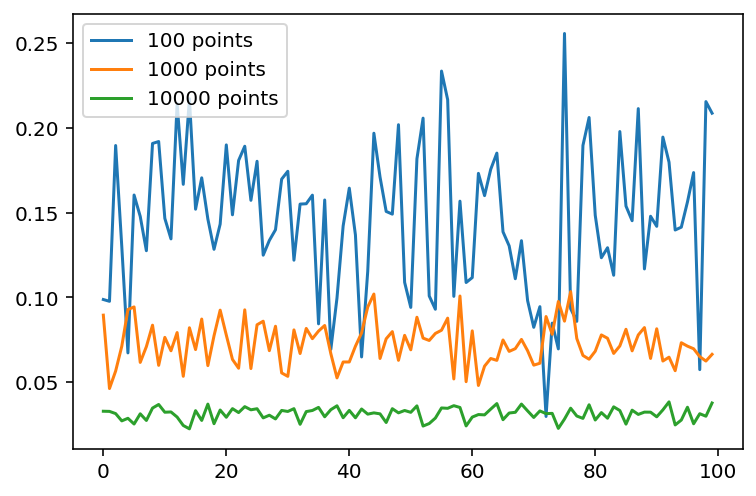

In [6]:
plt.plot(h100, label='100 points')
plt.plot(h1000, label='1000 points')
plt.plot(h10000, label='10000 points')
plt.legend();

More points from original distribution, more accurate the result

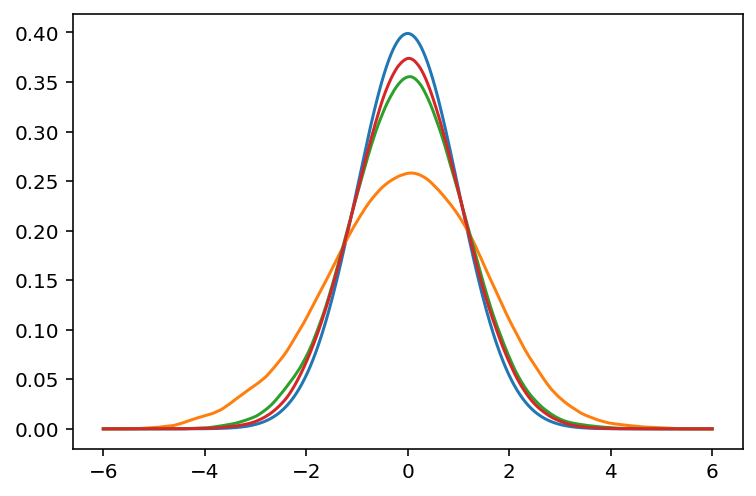

In [8]:
plt.plot(xgrid, norm(0,1).pdf(xgrid))
plt.plot(xgrid, kde100)
plt.plot(xgrid, kde1000)
plt.plot(xgrid, kde10000)

## Testing bandwidth factors

In [9]:
# different bw
xgrid = np.linspace(-6, 6, 100000)
Niter = 100
hbw, hbw2, hbw5 = np.zeros(Niter), np.zeros(Niter), np.zeros(Niter)

for ii in range(Niter):
    n10000 = np.random.normal(0, 1, size=10000)
    
    bwsj = bw.sj(n10000)
    bwsj2 = bw.sj(n10000)*2.214
    bwsj5 = bw.sj(n10000)*5
    
    kde1 = FFTKDE(bw=bwsj, kernel='epa').fit(n10000).evaluate(xgrid)
    kde2 = FFTKDE(bw=bwsj2, kernel='epa').fit(n10000).evaluate(xgrid)
    kde3 = FFTKDE(bw=bwsj5, kernel='epa').fit(n10000).evaluate(xgrid)
    
    hbw[ii] = hellinger(kde1, xgrid)
    hbw2[ii] = hellinger(kde2, xgrid)
    hbw5[ii] = hellinger(kde3, xgrid)

/tmp/ipykernel_11974/2391291908.py:7: RuntimeWarning: invalid value encountered in sqrt
  H2 = 1 - np.sum(np.sqrt(gx * np.exp(-xgrid**2/2)/np.sqrt(2*np.pi)))*dx


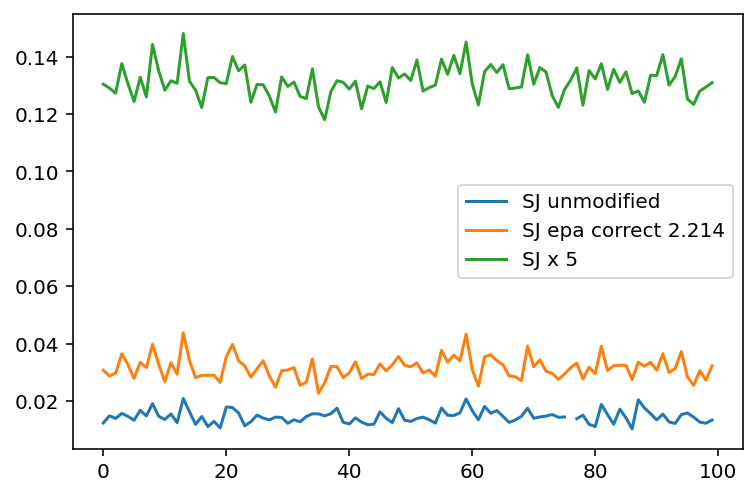

In [10]:
plt.plot(hbw, label='SJ unmodified')
plt.plot(hbw2, label='SJ epa correct 2.214')
plt.plot(hbw5, label='SJ x 5')
plt.legend();

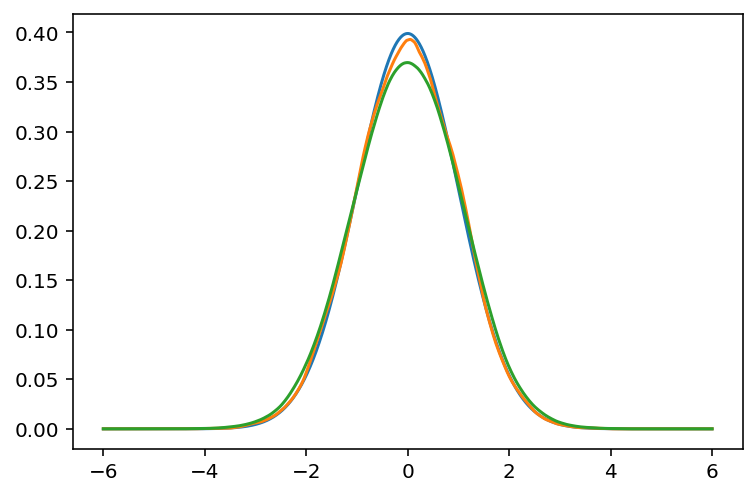

In [11]:
plt.plot(xgrid, norm(0,1).pdf(xgrid))
plt.plot(xgrid, kde1)
plt.plot(xgrid, kde2)

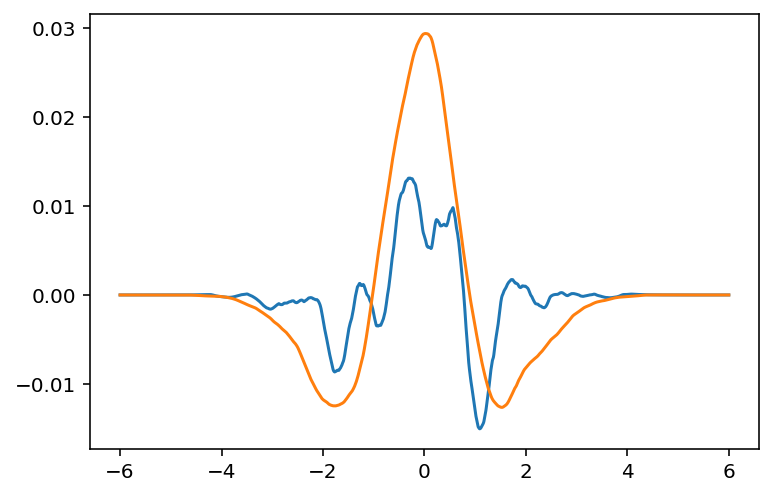

In [13]:
plt.plot(xgrid, norm(0,1).pdf(xgrid)-kde1)
plt.plot(xgrid, norm(0,1).pdf(xgrid)-kde2)

In [14]:
# different bw
xgrid = np.linspace(-6, 6, 100000)
Niter = 100
hbw, hbw2, hbw5 = np.zeros(Niter), np.zeros(Niter), np.zeros(Niter)

for ii in range(Niter):
    n10000 = np.random.normal(0, 1, size=10000)
    
    bwsj = bw.sj(n10000)
    bwsj2 = bw.sj(n10000)*0.5
    bwsj5 = bw.sj(n10000)*0.1
    
    kde1 = FFTKDE(bw=bwsj, kernel='epa').fit(n10000).evaluate(xgrid)
    kde2 = FFTKDE(bw=bwsj2, kernel='epa').fit(n10000).evaluate(xgrid)
    kde3 = FFTKDE(bw=bwsj5, kernel='epa').fit(n10000).evaluate(xgrid)
    
    hbw[ii] = hellinger(kde1, xgrid)
    hbw2[ii] = hellinger(kde2, xgrid)
    hbw5[ii] = hellinger(kde3, xgrid)

/tmp/ipykernel_11974/2391291908.py:7: RuntimeWarning: invalid value encountered in sqrt
  H2 = 1 - np.sum(np.sqrt(gx * np.exp(-xgrid**2/2)/np.sqrt(2*np.pi)))*dx
/tmp/ipykernel_11974/2391291908.py:7: RuntimeWarning: invalid value encountered in sqrt
  H2 = 1 - np.sum(np.sqrt(gx * np.exp(-xgrid**2/2)/np.sqrt(2*np.pi)))*dx


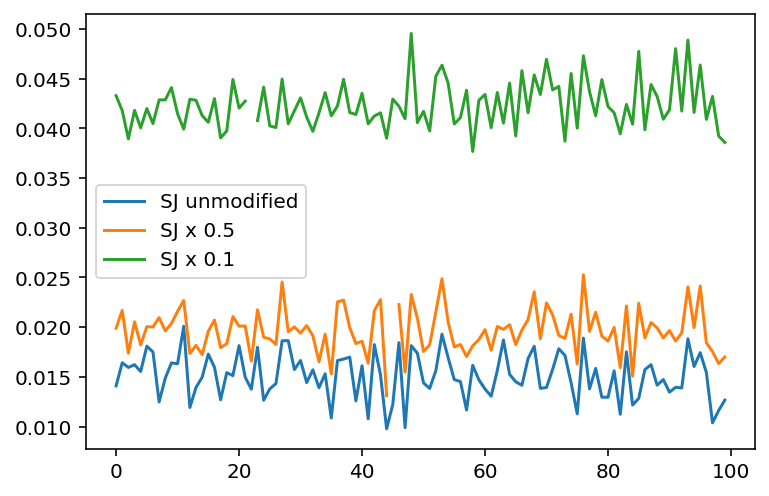

In [15]:
plt.plot(hbw, label='SJ unmodified')
plt.plot(hbw2, label='SJ x 0.5')
plt.plot(hbw5, label='SJ x 0.1')
plt.legend();

For a normal, don't modify Hellinger?

## Trying different kernels

In [16]:
# different bw
xgrid = np.linspace(-6, 6, 100000)
Niter = 100
hepa, hgauss, hisj = np.zeros(Niter), np.zeros(Niter), np.zeros(Niter)

for ii in range(Niter):
    n10000 = np.random.normal(0, 1, size=10000)
    bw1 = bw.sj(n10000)
    
    kde1 = FFTKDE(bw=bw1, kernel='gaussian').fit(n10000).evaluate(xgrid)
    kde2 = FFTKDE(bw=bw1, kernel='epa').fit(n10000).evaluate(xgrid)
    kde3 = FFTKDE(bw=bw1*2.214, kernel='epa').fit(n10000).evaluate(xgrid)
    
    hgauss[ii] = hellinger(kde1, xgrid)
    hepa[ii] = hellinger(kde2, xgrid)
    hisj[ii] = hellinger(kde3, xgrid)

/tmp/ipykernel_11974/2391291908.py:7: RuntimeWarning: invalid value encountered in sqrt
  H2 = 1 - np.sum(np.sqrt(gx * np.exp(-xgrid**2/2)/np.sqrt(2*np.pi)))*dx
/tmp/ipykernel_11974/2391291908.py:7: RuntimeWarning: invalid value encountered in sqrt
  H2 = 1 - np.sum(np.sqrt(gx * np.exp(-xgrid**2/2)/np.sqrt(2*np.pi)))*dx


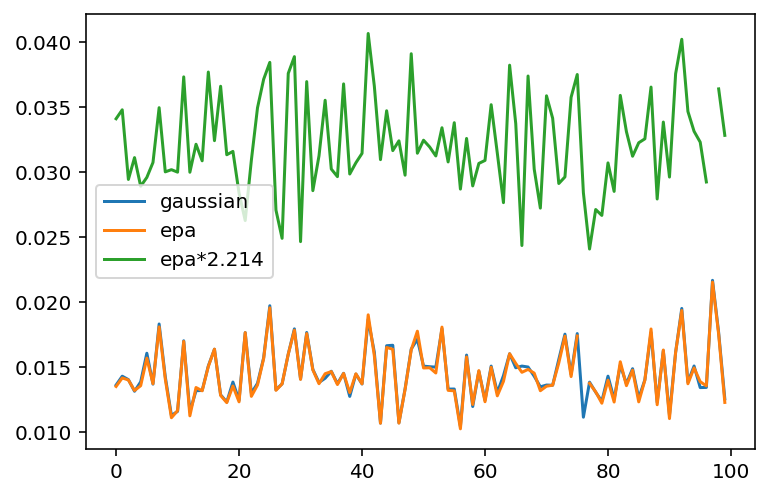

In [17]:
plt.plot(hgauss, label='gaussian')
plt.plot(hepa, label='epa')
plt.plot(hisj, label='epa*2.214')
plt.legend();

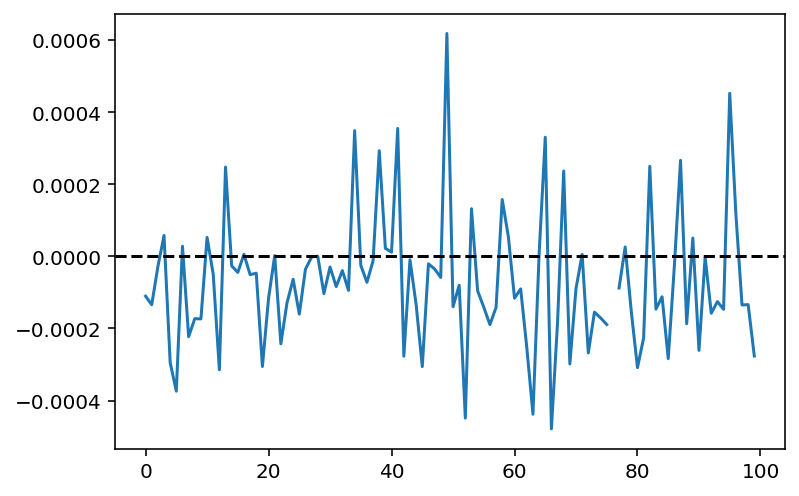

In [18]:
plt.plot(hepa-hgauss)
plt.axhline(0, c='k', ls='--');

SJ with Epanechnikov best

## different kernels and bandwidths

In [257]:
# different bw
xgrid = np.linspace(-6, 6, 100000)
Niter = 100
hsj, hscott, hsilverman, hisj = np.zeros(Niter), np.zeros(Niter), np.zeros(Niter), np.zeros(Niter)

for ii in range(Niter):
    n10000 = np.random.normal(0, 1, size=10000)
    bw1 = bw.sj(n10000)
    
    kde1 = FFTKDE(bw=bw1, kernel='epa').fit(n10000).evaluate(xgrid)
    kde2 = FFTKDE(bw='scott', kernel='gaussian').fit(n10000).evaluate(xgrid)
    kde3 = FFTKDE(bw='silverman', kernel='gaussian').fit(n10000).evaluate(xgrid)
    kde4 = FFTKDE(bw='ISJ', kernel='epa').fit(n10000).evaluate(xgrid)
    
    hsj[ii] = hellinger(kde1, xgrid)
    hscott[ii] = hellinger(kde2, xgrid)
    hsilverman[ii] = hellinger(kde3, xgrid)
    hisj[ii] = hellinger(kde4, xgrid)

/tmp/ipykernel_165650/2757747305.py:3: RuntimeWarning: invalid value encountered in sqrt
  H2 = 1 - np.sum(np.sqrt(gx * np.exp(-xgrid**2/2)/np.sqrt(2*np.pi)))*dx
/tmp/ipykernel_165650/2757747305.py:3: RuntimeWarning: invalid value encountered in sqrt
  H2 = 1 - np.sum(np.sqrt(gx * np.exp(-xgrid**2/2)/np.sqrt(2*np.pi)))*dx
/tmp/ipykernel_165650/2757747305.py:3: RuntimeWarning: invalid value encountered in sqrt
  H2 = 1 - np.sum(np.sqrt(gx * np.exp(-xgrid**2/2)/np.sqrt(2*np.pi)))*dx
/tmp/ipykernel_165650/2757747305.py:3: RuntimeWarning: invalid value encountered in sqrt
  H2 = 1 - np.sum(np.sqrt(gx * np.exp(-xgrid**2/2)/np.sqrt(2*np.pi)))*dx
/tmp/ipykernel_165650/2757747305.py:3: RuntimeWarning: invalid value encountered in sqrt
  H2 = 1 - np.sum(np.sqrt(gx * np.exp(-xgrid**2/2)/np.sqrt(2*np.pi)))*dx


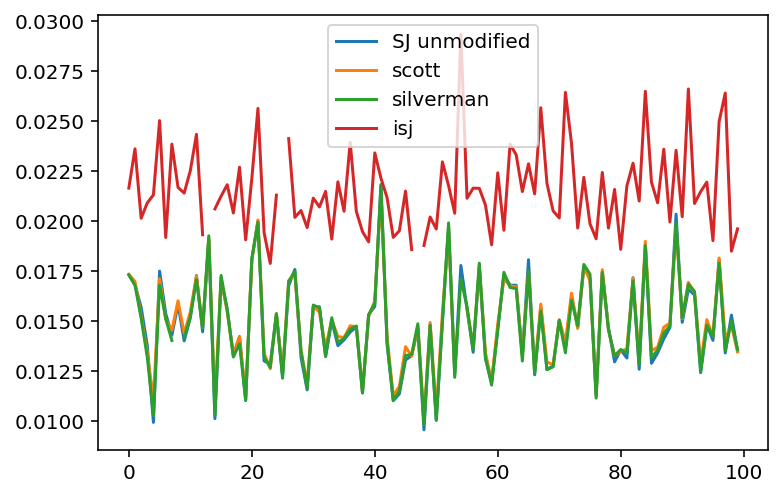

In [258]:
plt.plot(hsj, label='SJ unmodified')
plt.plot(hscott, label='scott')
plt.plot(hsilverman, label='silverman')
plt.plot(hisj, label='isj')
plt.legend();

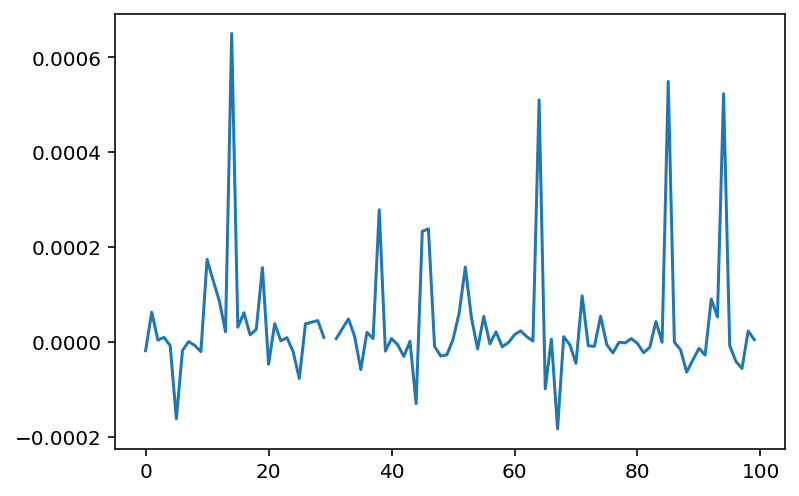

In [137]:
plt.plot(hsj-hsilverman)

In [259]:
len(hsj[(hsj-hsilverman) < 0])

58

In [253]:
# different bw
xgrid = np.linspace(-6, 6, 100000)
Niter = 100
hsj, hscott, hsilverman, hisj = np.zeros(Niter), np.zeros(Niter), np.zeros(Niter), np.zeros(Niter)
norm_pdf = norm(0,1).pdf(xgrid)

for ii in range(Niter):
    n10000 = np.random.normal(0, 1, size=10000)
    bw1 = bw.sj(n10000)
    
    kde1 = FFTKDE(bw=bw1, kernel='epa').fit(n10000).evaluate(xgrid)
    kde2 = FFTKDE(bw='scott', kernel='gaussian').fit(n10000).evaluate(xgrid)
    kde3 = FFTKDE(bw='silverman', kernel='gaussian').fit(n10000).evaluate(xgrid)
    kde4 = FFTKDE(bw='ISJ', kernel='gaussian').fit(n10000).evaluate(xgrid)
    
    hsj[ii] = general_hellinger(norm_pdf, kde1, xgrid=xgrid)
    hscott[ii] = general_hellinger(norm_pdf, kde2, xgrid=xgrid)
    hsilverman[ii] = general_hellinger(norm_pdf, kde3, xgrid=xgrid)
    hisj[ii] = general_hellinger(norm_pdf, kde4, xgrid=xgrid)

/tmp/ipykernel_165650/750039579.py:3: RuntimeWarning: invalid value encountered in sqrt
  H2 = 1 - np.sum(np.sqrt(fx * gx))*dx
/tmp/ipykernel_165650/750039579.py:3: RuntimeWarning: invalid value encountered in sqrt
  H2 = 1 - np.sum(np.sqrt(fx * gx))*dx
/tmp/ipykernel_165650/750039579.py:3: RuntimeWarning: invalid value encountered in sqrt
  H2 = 1 - np.sum(np.sqrt(fx * gx))*dx
/tmp/ipykernel_165650/750039579.py:3: RuntimeWarning: invalid value encountered in sqrt
  H2 = 1 - np.sum(np.sqrt(fx * gx))*dx
/tmp/ipykernel_165650/750039579.py:3: RuntimeWarning: invalid value encountered in sqrt
  H2 = 1 - np.sum(np.sqrt(fx * gx))*dx
/tmp/ipykernel_165650/750039579.py:3: RuntimeWarning: invalid value encountered in sqrt
  H2 = 1 - np.sum(np.sqrt(fx * gx))*dx
/tmp/ipykernel_165650/750039579.py:3: RuntimeWarning: invalid value encountered in sqrt
  H2 = 1 - np.sum(np.sqrt(fx * gx))*dx
/tmp/ipykernel_165650/750039579.py:3: RuntimeWarning: invalid value encountered in sqrt
  H2 = 1 - np.sum(np.sq

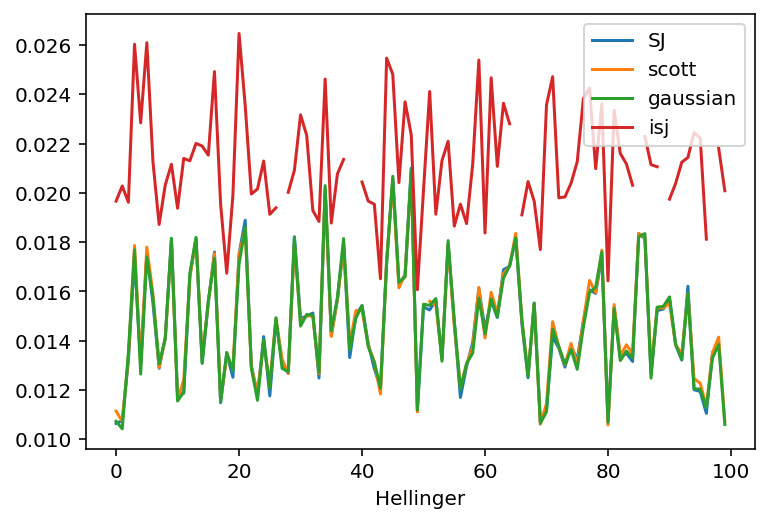

In [254]:
plt.plot(hsj, label='SJ')
plt.plot(hscott, label='scott')
plt.plot(hsilverman, label='gaussian')
plt.plot(hisj, label='isj')
plt.xlabel('Hellinger')
plt.legend();

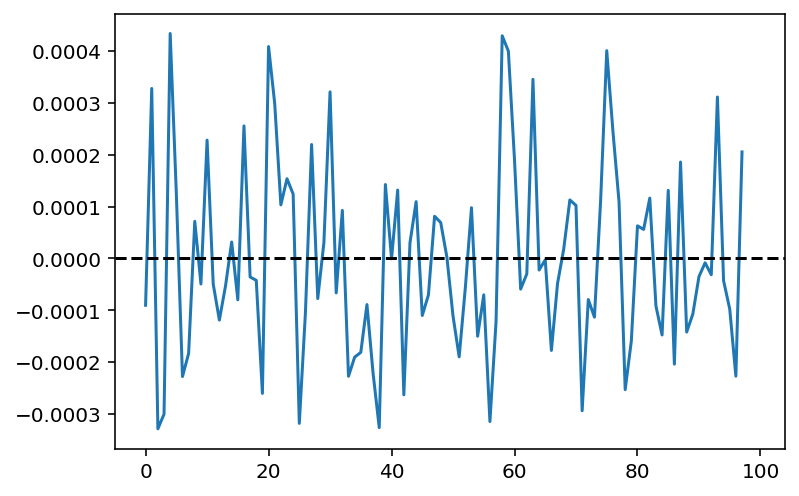

In [255]:
plt.plot(hsj-hsilverman)
plt.axhline(0, c='k', ls='--')

In [256]:
len(hsj[(hsj-hsilverman) < 0])

56

ISJ is just bad

Not much difference between other kernels and bandwidths (Silverman + Gaussian actually better sometimes) but this is for a Gaussian. More complex shapes, SJ and Epanechnikov is better

## Trying other scipy stats objects

In [27]:
from scipy.stats import rayleigh

In [30]:
xgrid = np.linspace(0, 5, 1000)

In [31]:
ray = rayleigh().pdf(xgrid)

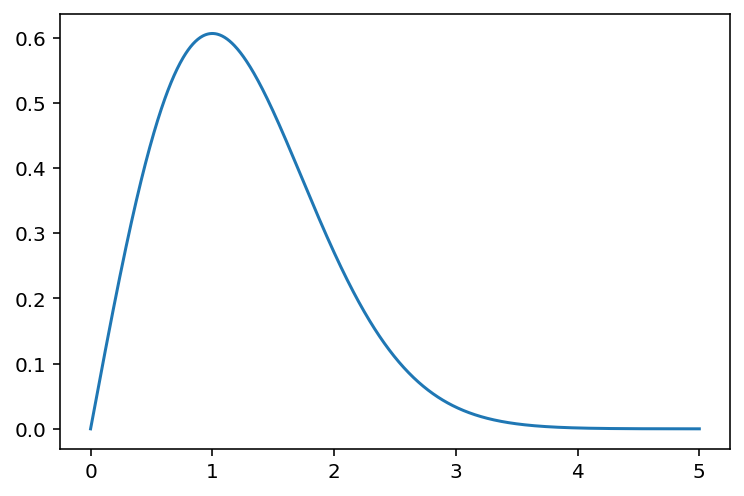

In [32]:
plt.plot(xgrid, ray)

In [58]:
# different bw
xgrid = np.linspace(0, 6, 100000)
Niter = 100
hsj, hscott, hsilverman = np.zeros(Niter), np.zeros(Niter), np.zeros(Niter)
invgauss = rayleigh().pdf(xgrid)
for ii in range(Niter):
    n10000 = rayleigh().rvs(10000)
    bw1 = bw.sj(n10000)
    
    kde1 = FFTKDE(bw=bw1, kernel='epa').fit(n10000).evaluate(xgrid)
    kde2 = FFTKDE(bw='silverman', kernel='gaussian').fit(n10000).evaluate(xgrid)
    kde3 = FFTKDE(bw=bw1*2.214, kernel='epa').fit(n10000).evaluate(xgrid)
    
    hsj[ii] = general_hellinger(invgauss, kde1, xgrid=xgrid)
    hscott[ii] = general_hellinger(invgauss, kde2, xgrid=xgrid)
    hsilverman[ii] = general_hellinger(invgauss, kde3, xgrid=xgrid)

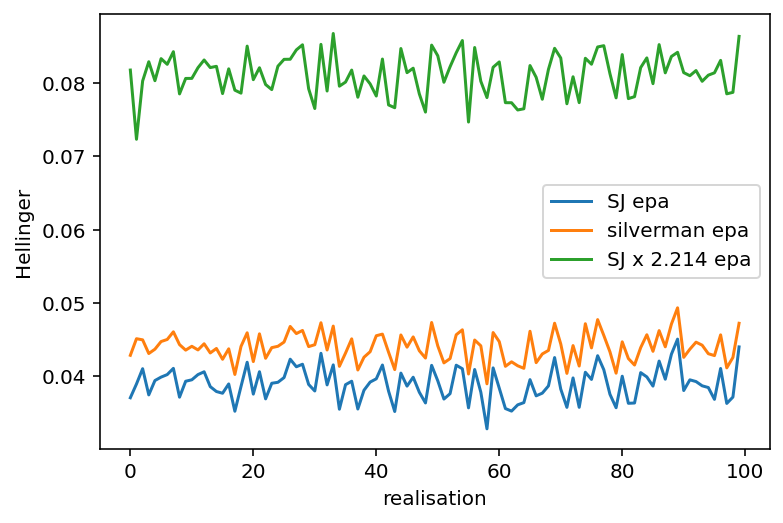

In [61]:
plt.plot(hsj, label='SJ epa')
plt.plot(hscott, label='silverman epa')
plt.plot(hsilverman, label='SJ x 2.214 epa')
plt.xlabel('realisation')
plt.ylabel('Hellinger')
plt.legend();

In [23]:
# different bw
xgrid = np.linspace(-10, 12, 100000)
Niter = 100
hsj, hscott, hsilverman = np.zeros(Niter), np.zeros(Niter), np.zeros(Niter)
norm2_pdf = (norm(0, 1).pdf(xgrid) + norm(1, 0.75).pdf(xgrid))/2

for ii in range(Niter):
    n10000 = np.hstack((np.random.normal(0,1,5000),
                        np.random.normal(1,0.75,5000)))
    bw1 = bw.sj(n10000)
    
    kde1 = FFTKDE(bw=bw1, kernel='epa').fit(n10000).evaluate(xgrid)
    kde2 = FFTKDE(bw='silverman', kernel='gaussian').fit(n10000).evaluate(xgrid)
    kde3 = FFTKDE(bw='silverman', kernel='epa').fit(n10000).evaluate(xgrid)
    
    hsj[ii] = general_hellinger(norm2_pdf, kde1, xgrid=xgrid)
    hscott[ii] = general_hellinger(norm2_pdf, kde2, xgrid=xgrid)
    hsilverman[ii] = general_hellinger(norm2_pdf, kde3, xgrid=xgrid)

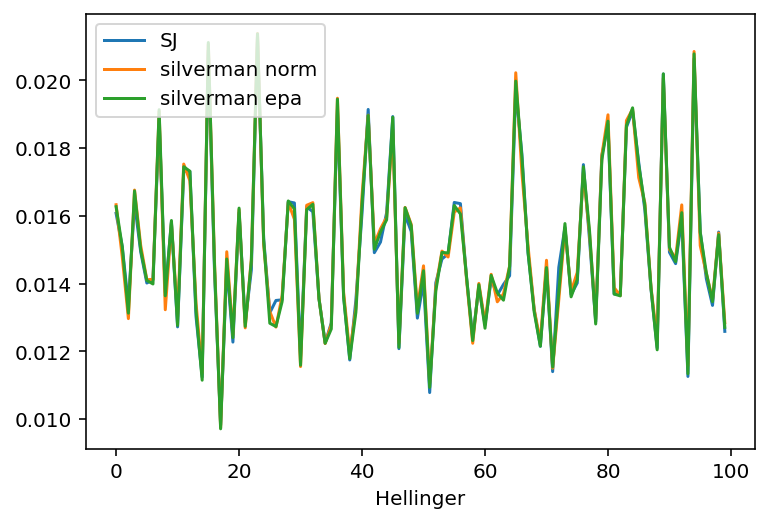

In [24]:
plt.plot(hsj, label='SJ')
plt.plot(hscott, label='silverman norm')
plt.plot(hsilverman, label='silverman epa')
plt.xlabel('Hellinger')
plt.legend();

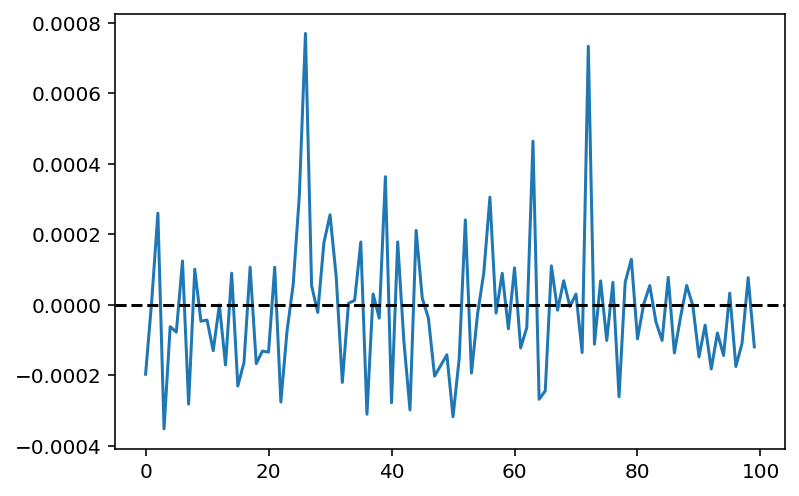

In [25]:
plt.plot(hsj-hsilverman)
plt.axhline(0, ls='--', c='k')

In [26]:
len(hsj[hsj-hsilverman < 0])

58

## trying awkde

In [2]:
from awkde import GaussianKDE

In [19]:
# different bw
xgrid = np.linspace(-6, 6, 100000)
Niter = 5
hsj, hsilverman, awsilverman, awsj = np.zeros(Niter), np.zeros(Niter), np.zeros(Niter), np.zeros(Niter)
norm_pdf = norm(0,1).pdf(xgrid)

for ii in range(Niter):
    n10000 = np.random.normal(0, 1, size=10000)
    bw1 = bw.sj(n10000)
    
    kde1 = FFTKDE(bw=bw1, kernel='epa').fit(n10000).evaluate(xgrid)
    kde2 = FFTKDE(bw='silverman', kernel='epa').fit(n10000).evaluate(xgrid)
    kde3 = GaussianKDE()
    kde3.fit(n10000.reshape(-1,1))
    kde3 = kde3.predict(xgrid.reshape(-1,1))
    
    kde4 = GaussianKDE(glob_bw=bw1)
    kde4.fit(n10000.reshape(-1,1))
    kde4 = kde4.predict(xgrid.reshape(-1,1))
    
    hsj[ii] = general_hellinger(norm_pdf, kde1, xgrid=xgrid)
    hsilverman[ii] = general_hellinger(norm_pdf, kde2, xgrid=xgrid)
    awsilverman[ii] = general_hellinger(norm_pdf, kde3, xgrid=xgrid)
    awsj[ii] = general_hellinger(norm_pdf, kde4, xgrid=xgrid)

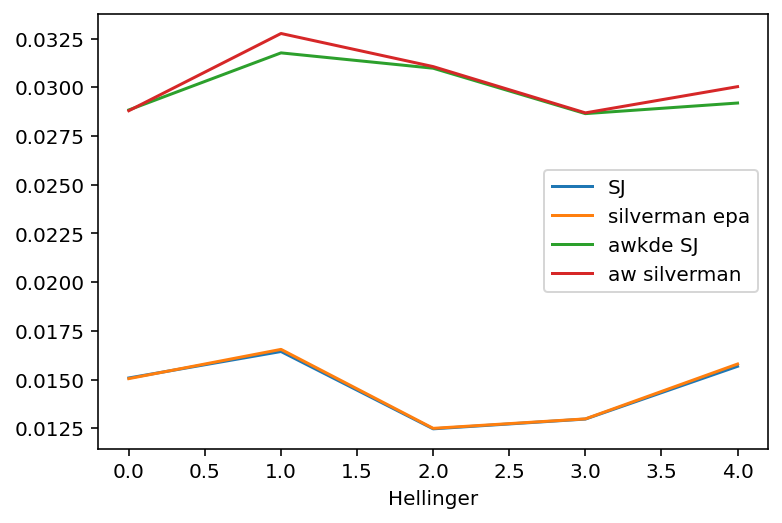

In [21]:
plt.plot(hsj, label='SJ')
plt.plot(hsilverman, label='silverman epa')
plt.plot(awsj, label='awkde SJ')
plt.plot(awsilverman, label='aw silverman')
plt.xlabel('Hellinger')
plt.legend();

In [35]:
# different bw
xgrid = np.linspace(-6, 6, 100000)
Niter = 100
hsj, hsilverman, awsilverman, awsj = np.zeros(Niter), np.zeros(Niter), np.zeros(Niter), np.zeros(Niter)
norm_pdf = (norm(0, 1).pdf(xgrid) + norm(1, 0.75).pdf(xgrid))/2

for ii in range(Niter):
    n10000 = np.hstack((np.random.normal(0,1,5000),
                        np.random.normal(1,0.75,5000)))
    bw1 = bw.sj(n10000)
    
    kde1 = FFTKDE(bw=bw1, kernel='epa').fit(n10000).evaluate(xgrid)
    kde2 = FFTKDE(bw='silverman', kernel='epa').fit(n10000).evaluate(xgrid)
    kde3 = GaussianKDE()
    kde3.fit(n10000.reshape(-1,1))
    kde3 = kde3.predict(xgrid.reshape(-1,1))
    
    kde4 = GaussianKDE(glob_bw=bw1)
    kde4.fit(n10000.reshape(-1,1))
    kde4 = kde4.predict(xgrid.reshape(-1,1))
    
    hsj[ii] = general_hellinger(norm_pdf, kde1, xgrid=xgrid)
    hsilverman[ii] = general_hellinger(norm_pdf, kde2, xgrid=xgrid)
    awsilverman[ii] = general_hellinger(norm_pdf, kde3, xgrid=xgrid)
    awsj[ii] = general_hellinger(norm_pdf, kde4, xgrid=xgrid)

/tmp/ipykernel_276725/2249454914.py:7: RuntimeWarning: invalid value encountered in sqrt
  H2 = 1 - np.sum(np.sqrt(fx * gx))*dx


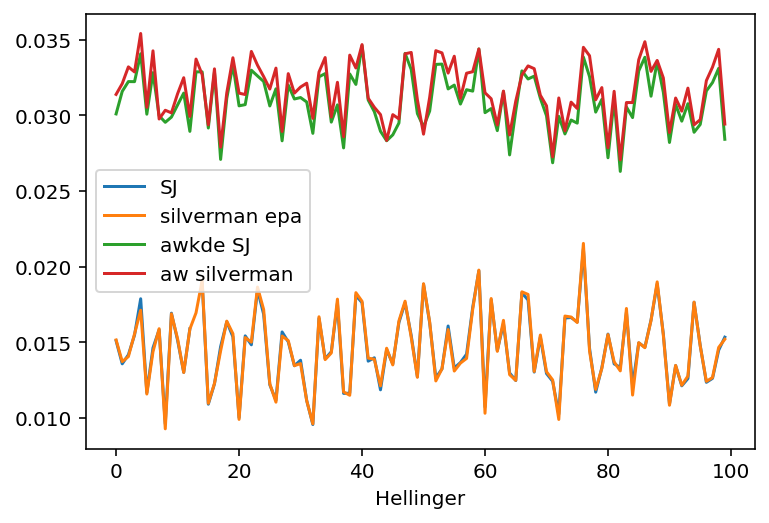

In [36]:
plt.plot(hsj, label='SJ')
plt.plot(hsilverman, label='silverman epa')
plt.plot(awsj, label='awkde SJ')
plt.plot(awsilverman, label='aw silverman')
plt.xlabel('Hellinger')
plt.legend();

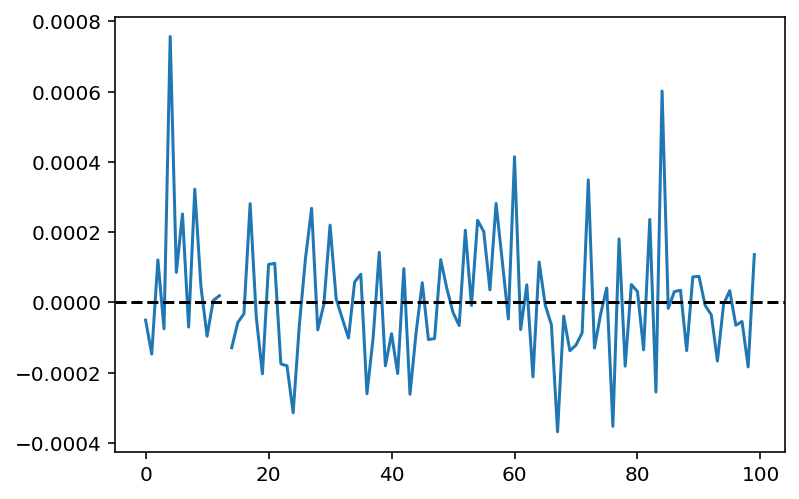

In [40]:
plt.plot(hsj-hsilverman)
plt.axhline(0, ls='--', c='k')

In [38]:
len(hsj[hsj-hsilverman < 0])

55

SJ best... so just change bandwidth to be just SJ!